In [1]:
from fmm import Network,NetworkGraph,FastMapMatch,FastMapMatchConfig,UBODT
from metrics import precision_length, precision_segment, recall_segment, recall_length, route_error, analyze_spatial_skewing_meters, analyze_spatial_skewing_metersV2, analyze_spatial_skewing_metersV3
import pandas as pd
from shapely.wkt import loads
from shapely.geometry import mapping
import tracers as tr
import numpy as np

#load network data and graph 
network = Network("../osmnx_example/rome/edges.shp","fid", "u", "v")
print("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

ubodt = UBODT.read_ubodt_csv("../osmnx_example/rome/ubodt.txt")

model = FastMapMatch(network,graph,ubodt)

#load taxi data
df = pd.read_csv("../osmnx_example/rome/original_taxi_156.csv", sep=";")


wkt = df.loc[df["id"] == 156, "geom"].values[0]
print("raw wtk: ", wkt)

# configuration parameters
k = 10
radius = 400/100_000
gps_error = 75/100_000

fmm_config = FastMapMatchConfig(k,radius,gps_error,obfuscation=False, reverse_tolerance=10)

result_raw = model.match_wkt(wkt,fmm_config)

gt_wtk = loads(result_raw.mgeom.export_wkt())


[2025-03-13 14:43:05.936] [info] [network.cpp:72] Read network from file ../osmnx_example/rome/edges.shp
Nodes 94381 edges 203971
[2025-03-13 14:43:08.424] [info] [network.cpp:172] Number of edges 203971 nodes 94381
[2025-03-13 14:43:08.424] [info] [network.cpp:173] Field index: id 19 source 0 target 1
[2025-03-13 14:43:08.593] [info] [network.cpp:176] Read network done.
[2025-03-13 14:43:08.595] [info] [network_graph.cpp:17] Construct graph from network edges start
[2025-03-13 14:43:08.619] [info] [network_graph.cpp:30] Graph nodes 94381 edges 203971
[2025-03-13 14:43:08.619] [info] [network_graph.cpp:31] Construct graph from network edges end
[2025-03-13 14:43:08.619] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from ../osmnx_example/rome/ubodt.txt
[2025-03-13 14:43:09.556] [info] [ubodt.cpp:236] Read rows 1000000
[2025-03-13 14:43:10.337] [info] [ubodt.cpp:236] Read rows 2000000
[2025-03-13 14:43:11.235] [info] [ubodt.cpp:236] Read rows 3000000
[2025-03-13 14:43:12.208] [i

In [2]:
#perturbated data map matching
df_pert = pd.read_csv("../osmnx_example/rome/pert_taxi_156.csv", sep=";")

wkt_pert = df_pert.loc[df["id"] == 156, "geom"].values[0]

k = 8
# devide by 100 000 to go from meter to degrees
radius = 400/100_000
gps_error = 75/100_000
obfuscation_error = 300/100_000
total_error = np.sqrt(gps_error**2 + obfuscation_error**2)
fmm_config = FastMapMatchConfig(k,radius,total_error,obfuscation=False,reverse_tolerance=10)
result_pert = model.match_wkt(wkt_pert,fmm_config)

pert_mm_wtk = loads(result_pert.mgeom.export_wkt())



In [3]:
# error metric van https://doi.org/10.1145/1653771.1653818
# Load geometries from WKT
print(wkt)
print(gt_wtk)
print(pert_mm_wtk)
print(result_pert.mgeom.export_wkt())

error_metrics = route_error(gt_wtk, pert_mm_wtk)

# Print results
print(f"Correct route length (d0): {error_metrics['d0']:.2f}")
print(f"Erroneously subtracted (d-): {error_metrics['d_minus']:.2f}")
print(f"Erroneously added (d+): {error_metrics['d_plus']:.2f}")
print(f"Error metric: {error_metrics['error']:.4f}")

skewing_metrics = analyze_spatial_skewing_metersV2(gt_wtk, pert_mm_wtk)


LINESTRING (12.4877775603346 41.8836718276551, 12.4884353827295 41.8836033504296, 12.4896847523146 41.8837570851804, 12.4917861510387 41.8825124308017, 12.4930700915813 41.8817298456516, 12.4930847614908 41.8817244261193, 12.4943850948656 41.8809138947523, 12.4954783104944 41.8799696775646, 12.4956542118986 41.8798316726586, 12.4956542118986 41.8798316726586, 12.4956542118986 41.8798316726586, 12.4958343095006 41.8797890961217, 12.4970601405625 41.8807648722839, 12.4981836939397 41.8821382549306, 12.4994099491515 41.8820425634678, 12.5009581619821 41.8816928858272, 12.5025033131254 41.8812923931109, 12.5031437908271 41.8811376037395, 12.5031437908271 41.8811376037395, 12.5031437908271 41.8811376037395, 12.5031437908271 41.8811376037395, 12.5036670187672 41.8810570627483, 12.5055134035102 41.8807108208984, 12.5072098900473 41.8804656761764, 12.5079575195641 41.8803491669139, 12.5079575195641 41.8803491669139, 12.5079575195641 41.8803491669139, 12.5079575195641 41.8803491669139, 12.50831

LINESTRING (12.4879 41.883584, 12.487937 41.883568, 12.487963 41.883561, 12.488028 41.883546, 12.488045 41.883544, 12.488073 41.883541, 12.488118 41.883537, 12.488137 41.883536, 12.488154 41.883535, 12.488197 41.883536, 12.488238 41.883538, 12.488778 41.883957, 12.488805 41.883979, 12.488835 41.884004, 12.488847 41.884013, 12.48905 41.884184, 12.489097 41.88415, 12.489496 41.883904, 12.48956 41.883862, 12.490049 41.883542, 12.490157 41.883474, 12.490326 41.883387, 12.490766 41.883187, 12.491412 41.88279, 12.492705 41.881998, 12.493244 41.881673, 12.49332 41.881627, 12.493382 41.881587, 12.493436 41.881552, 12.495022 41.880564, 12.495164 41.880432, 12.495198 41.880399, 12.495229 41.880363, 12.495256 41.880328, 12.495276 41.880299, 12.495302 41.880252, 12.495324 41.880207, 12.495361 41.880106, 12.495373 41.880076, 12.495385 41.880049, 12.4954 41.880022, 12.495414 41.879998, 12.495429 41.879976, 12.495442 41.879958, 12.495464 41.879934, 12.495484 41.879915, 12.4955 41.879903, 12.495526 41

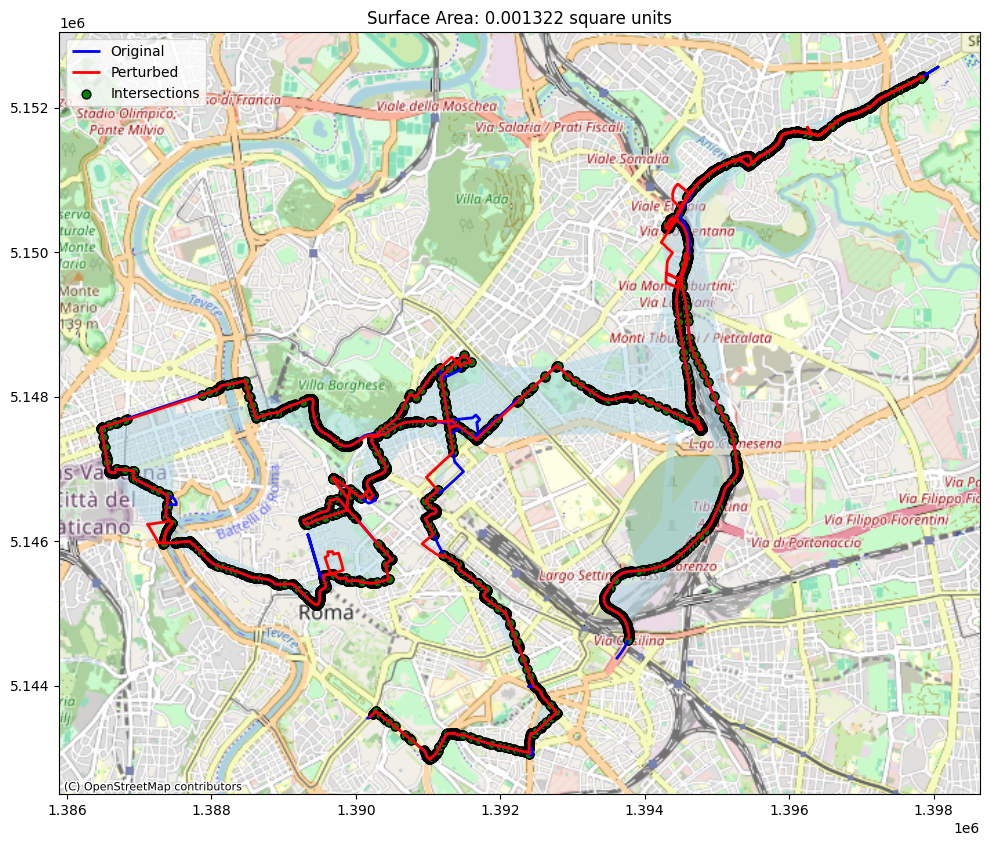

Surface area between the lines: 0.001322 square units


In [7]:
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import LineString, Polygon, Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from rtree import index


def find_segment_intersections(line1, line2):
    """Find all intersections between segments of two lines"""
    intersections = []
    
    #DEBUG
    print(line1)
    print(line2)

    # Create segments for first line
    segments1 = []
    print("calculating segments 1")
    for i in range(len(line1.coords) - 1):
        seg = LineString([line1.coords[i], line1.coords[i+1]])
        segments1.append((i, seg))
    
    # Create segments for second line and build spatial index
    print("calculating segments 2")
    segments2 = []
    idx = index.Index()
    for i in range(len(line2.coords) - 1):
        seg = LineString([line2.coords[i], line2.coords[i+1]])
        segments2.append((i, seg))
        idx.insert(i, seg.bounds)
    
    # Check for intersections using spatial index
    for i, (idx1, seg1) in enumerate(segments1):
        # Find potential intersections using bounding box
        potential_matches = list(idx.intersection(seg1.bounds))
        
        for j, idx2 in enumerate(potential_matches):
            seg2 = segments2[idx2][1]
            if seg1.intersects(seg2):
                intersection = seg1.intersection(seg2)
                if isinstance(intersection, Point):
                    # Calculate distances along each line
                    dist1 = line1.project(intersection)
                    dist2 = line2.project(intersection)
                    
                    intersections.append({
                        'point': intersection,
                        'seg1_idx': idx1,
                        'seg2_idx': idx2,
                        'dist1': dist1,
                        'dist2': dist2
                    })
    
    return intersections

def split_line_at_points(line, split_points):
    """Split a line at given points and return the new line with additional vertices"""
    if not split_points:
        return line
    
    # Convert to list for manipulation
    coords = list(line.coords)
    
    # Sort split points by distance along the line
    split_points.sort(key=lambda x: x['dist'])
    
    # Convert coords to numpy array for faster distance calculation
    coords_array = np.array(coords)
    
    # Insert points
    added = 0
    for point_info in split_points:
        point = point_info['point']
        seg_idx = point_info['seg_idx']
        
        # Skip if the point is already too close to an existing vertex (optimized calculation)
        point_coords = np.array([point.x, point.y])
        squared_dists = np.sum((coords_array - point_coords)**2, axis=1)
        min_squared_dist = np.min(squared_dists)
        
        # Using squared distance comparison (equivalent to 1e-8 for actual distance)
        if min_squared_dist < 1e-16:  # Squared version of 1e-8
            continue
            
        # Insert at the correct position
        insert_pos = seg_idx + 1 + added
        if insert_pos < len(coords):
            coords.insert(insert_pos, (point.x, point.y))
            added += 1
            
            # Update numpy array for future distance calculations
            coords_array = np.array(coords)
    
    return LineString(coords)

from shapely.geometry import LineString, Polygon, Point
from shapely.ops import unary_union
import numpy as np

def calculate_surface_area(wkt, wkt_pert):
    # Parse WKT strings to Shapely geometries
    line1 = wkt
    line2 = wkt_pert
    
    # Find intersections
    raw_intersections = find_segment_intersections(line1, line2)
    
    if raw_intersections:
        # Prepare split points for both lines in one pass
        split_points1 = []
        split_points2 = []
        
        for intr in raw_intersections:
            split_points1.append({
                'point': intr['point'],
                'seg_idx': intr['seg1_idx'],
                'dist': intr['dist1']
            })
            
            split_points2.append({
                'point': intr['point'],
                'seg_idx': intr['seg2_idx'],
                'dist': intr['dist2']
            })
        
        # Add intersection points to both lines
        line1 = split_line_at_points(line1, split_points1)
        line2 = split_line_at_points(line2, split_points2)
    
    # Get coordinates more efficiently
    coords1 = np.array(line1.coords)
    coords2 = np.array(line2.coords)
    
    # Pre-allocate polygon list with approximate size
    estimated_size = min(len(coords1), len(coords2)) - 1
    polygons = []
    #polygons.reserve = estimated_size  # Reserve space if possible
    total_area = 0
    
    # Create polygons between corresponding points - optimized loop
    for i in range(len(coords1) - 1):
        try:
            # Create quadrilateral vertices directly from numpy arrays when possible
            if i < len(coords2) - 1:
                polygon = Polygon([
                    (coords1[i, 0], coords1[i, 1]), 
                    (coords1[i+1, 0], coords1[i+1, 1]), 
                    (coords2[i+1, 0], coords2[i+1, 1]), 
                    (coords2[i, 0], coords2[i, 1])
                ])
                
                # Only check validity if needed
                if polygon.area > 0:
                    if polygon.is_valid:
                        polygons.append(polygon)
                        total_area += polygon.area
            else:
                break  # Exit early if we've run out of corresponding points
        except Exception as e:
            print(f"Error creating polygon at segment {i}: {e}")
    
    # Try to combine all polygons into one
    combined_polygon = None
    if polygons:
        try:
            combined_polygon = unary_union(polygons)
        except Exception as e:
            print(f"Error combining polygons: {e}")
    
    # Create result dictionary
    result = {
        'area': total_area,
        'polygons': polygons,
        'combined_polygon': combined_polygon,
        'line1': line1,
        'line2': line2,
        'intersections': [intr['point'] for intr in raw_intersections]
    }
    
    return result

import contextily as ctx

def plot_comparison(result):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Assume input data is in WGS84 (EPSG:4326) and convert to Web Mercator (EPSG:3857)
    crs = "EPSG:4326"
    
    # Plot the polygons
    if result['combined_polygon']:
        gdf_poly = gpd.GeoDataFrame(geometry=[result['combined_polygon']], crs=crs)
        gdf_poly = gdf_poly.to_crs(epsg=3857)
        gdf_poly.plot(ax=ax, color='lightblue', alpha=0.5)
    else:
        for poly in result['polygons']:
            gdf = gpd.GeoDataFrame(geometry=[poly], crs=crs)
            gdf = gdf.to_crs(epsg=3857)
            gdf.plot(ax=ax, color='lightblue', alpha=0.5)
    
    # Plot the lines
    gdf_line1 = gpd.GeoDataFrame(geometry=[result['line1']], crs=crs)
    gdf_line1 = gdf_line1.to_crs(epsg=3857)
    gdf_line1.plot(ax=ax, color='blue', linewidth=2, label='Original')
    
    gdf_line2 = gpd.GeoDataFrame(geometry=[result['line2']], crs=crs)
    gdf_line2 = gdf_line2.to_crs(epsg=3857)
    gdf_line2.plot(ax=ax, color='red', linewidth=2, label='Perturbed')
    
    # Plot intersection points
    if result['intersections']:
        gdf_points = gpd.GeoDataFrame(geometry=result['intersections'], crs=crs)
        gdf_points = gdf_points.to_crs(epsg=3857)
        gdf_points.plot(ax=ax, color='green', markersize=40, marker='o', edgecolor='k', label='Intersections')
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    plt.legend()
    plt.title(f"Surface Area: {result['area']:.6f} square units")
    plt.tight_layout()
    return fig


result = calculate_surface_area(gt_wtk, pert_mm_wtk)
#result = calculate_surface_area(wkt, wkt_pert)
fig = plot_comparison(result)
plt.show()
print(f"Surface area between the lines: {result['area']:.6f} square units")